<a href="https://colab.research.google.com/github/JonCrook/icl-ml-portfolio/blob/main/M10_Tree_Ensembles_E_JonC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from sklearn import tree, ensemble
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from sklearn.inspection import permutation_importance

# Tree Ensembles 

## Assignment overview 

In this assignment you will build two types of tree ensemble models: Random Forest and Boosted. You will then investigate two methods for feature selection. 

###### Outline:


- [Part 1](#part1)- Importing the data set and formatting it 
- [Part 2](#part2)- Fitting a single decision tree
- [Part 3](#part3)- Using a Random Forest Classifier
- [Part 4](#part4)- Using the AdaBoost Classifier
- [Part 5](#part5)- Choosing the best classifier and retraining using all the samples, testing on the test set
- [Part 6](#part6)- Feature selection


[Back to top](#Index:) 

<a id='part1'></a>

### Part 1 - Importing the data set

For this excercise we will be using a data set from the University of Medicine and Pharmacy of Craiova, Romania to predict the hospitalisation period of patients after colon cancer operations based on socio-economic variables and clinical information. You can read more about the data and it's origins [here](https://figshare.com/articles/dataset/LOS_Colon_Cancer_621_cases/4747246/1). 

The data is stored in xlsx format again in the `colon_data.xlsx` file. Use the `read_excel()` function to load it.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_excel("/content/drive/MyDrive/ColabData/colon_data.xlsx")
len(df)

298

Use the `.head()` function to visulise the data.

In [ ]:
df.head(10)

,AGE,SEX,TOPOGRAPHY,STAGE,T,N,M,SURGERY,CLASS
0,64,M,rect,three,T4,Nx,Mx,ten,medium
1,70,M,rect,three,T4,Nx,Mx,ten,medium
2,76,F,cec,three,T3,Nx,Mx,three,medium
3,62,M,cec,three,T2,Nx,Mx,three,short
4,62,M,cec,two,T2,Nx,Mx,three,short
5,62,F,cec,two,T2,Nx,Mx,three,short
6,41,M,cec,two,T3,Nx,Mx,three,medium
7,82,F,cec,two,T2,Nx,Mx,three,short
8,76,F,cec,two,T2,Nx,Mx,three,short
9,76,M,cec,three,T3,Nx,Mx,three,medium


In [ ]:
df['CLASS'].unique()

array(['medium', 'short', 'long'], dtype=object)

First we want to replace the categorical values of the output (the `CLASS` variable) with numerical values. Fill in the gaps below to use the `.replace()` function to do this.

In [ ]:
df['CLASS'].replace(to_replace=['short', 'medium', 'long'] , value=[1, 2, 3] , inplace=True) 

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 298 entries, 0 to 297
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   AGE         298 non-null    int64 
 1   SEX         298 non-null    object
 2   TOPOGRAPHY  298 non-null    object
 3   STAGE       298 non-null    object
 4   T           298 non-null    object
 5   N           298 non-null    object
 6   M           298 non-null    object
 7   SURGERY     298 non-null    object
 8   CLASS       298 non-null    int64 
dtypes: int64(2), object(7)
memory usage: 21.1+ KB


Now use the `get_dummies()` function to transform the other categorical variables to numerical ones. 

In [ ]:
df = pd.get_dummies(df)

The following cell is just to ensure the 'CLASS' variable is the last column.

In [ ]:
columns = df.columns.to_list()
columns.remove('CLASS')
df = df[columns + ['CLASS']]

In [ ]:
df.head(10)

,AGE,SEX_F,SEX_M,TOPOGRAPHY_cec,TOPOGRAPHY_colon_asc,TOPOGRAPHY_colon_desc,TOPOGRAPHY_colon_sigm,TOPOGRAPHY_colon_trans,TOPOGRAPHY_jonc_rect_sigm,TOPOGRAPHY_rect,...,N_N2,N_Nx,M_M0,M_M1,M_M1_hep,M_Mx,SURGERY_ten,SURGERY_three,SURGERY_two,CLASS
0,64,0,1,0,0,0,0,0,0,1,...,0,1,0,0,0,1,1,0,0,2
1,70,0,1,0,0,0,0,0,0,1,...,0,1,0,0,0,1,1,0,0,2
2,76,1,0,1,0,0,0,0,0,0,...,0,1,0,0,0,1,0,1,0,2
3,62,0,1,1,0,0,0,0,0,0,...,0,1,0,0,0,1,0,1,0,1
4,62,0,1,1,0,0,0,0,0,0,...,0,1,0,0,0,1,0,1,0,1
5,62,1,0,1,0,0,0,0,0,0,...,0,1,0,0,0,1,0,1,0,1
6,41,0,1,1,0,0,0,0,0,0,...,0,1,0,0,0,1,0,1,0,2
7,82,1,0,1,0,0,0,0,0,0,...,0,1,0,0,0,1,0,1,0,1
8,76,1,0,1,0,0,0,0,0,0,...,0,1,0,0,0,1,0,1,0,1
9,76,0,1,1,0,0,0,0,0,0,...,0,1,0,0,0,1,0,1,0,2


We will now process the data similar to how we did for the loan data set activity.

Run the cell below to convert the `df` into a `NumPy` array

In [ ]:
Xy=np.array(df)

For reproducibility, set the random seed = 1. You can do this by using the `NumPy` function `random.seed()`. Assign your seed to the variable `seed`. Next, complete the code cell below by using the function `random.shuffle()` on `Xy`.

In [ ]:
seed = np.random.seed(1)
np.random.shuffle(Xy)


Before splitting the data into a training set, a test set, and a validation set, we need to divide `Xy` into two arrays: the first one, `X`, a 2D array containing all the predictors and the second, `y`, a 1D array with the response. 

Run the code cell below to generate `X`. Complete the remaining code to define `y`.

In [ ]:
X=Xy[:,:-1]
y=Xy[:,-1]

In [ ]:
#define y
y=Xy[:,-1]

Next, we need to split the messages into into 50% training data, 25% validation data, and 25% test data.

Run the code below to split `X` and `y` into training, validation and test sets.

In [ ]:
trainsize = int(len(df)/2)
trainplusvalsize = int(len(df)/4)
X_train=X[:trainsize]
X_val=X[trainsize:trainsize + trainplusvalsize]
X_test=X[trainsize + trainplusvalsize:]

y_train=y[:trainsize]
y_val=y[trainsize:trainsize + trainplusvalsize]
y_test=y[trainsize + trainplusvalsize:]

[Back to top](#Index:) 

<a id='part2'></a>

### Part 2: Fit a Single Decision Tree 

Use the same code as you used for the loan dataset notebook to fit decision trees with different depths up to `max_depth = 15`. Select the best depth - you will compare this to your tree ensemble methods later. 

In [ ]:
max_depth = 15
bestdepth=-1
bestscore = 0

for i in range(15):
    clf = tree.DecisionTreeClassifier(max_depth = i+1)
    #fit the training sets
    clf.fit(X_train, y_train)
    #update trainscore
    trainscore = clf.score(X_train, y_train)
    #update valscore
    valscore = clf.score(X_val, y_val)
    print( 'Depth:', i+1, 'Train Score:', round(trainscore, 4), 'Validation Score:', round(valscore, 4))
    if valscore > bestscore :
        #update bestscore
        bestscore = valscore
        #update depth
        bestdepth = i+1

print('Best depth=', bestdepth, 'best score=', bestscore)      

Depth: 1 Train Score: 0.7383 Validation Score: 0.6081
Depth: 2 Train Score: 0.7987 Validation Score: 0.6892
Depth: 3 Train Score: 0.8456 Validation Score: 0.7568
Depth: 4 Train Score: 0.8658 Validation Score: 0.7432
Depth: 5 Train Score: 0.9128 Validation Score: 0.7297
Depth: 6 Train Score: 0.9463 Validation Score: 0.7568
Depth: 7 Train Score: 0.9664 Validation Score: 0.7432
Depth: 8 Train Score: 0.9732 Validation Score: 0.7703
Depth: 9 Train Score: 0.9799 Validation Score: 0.7432
Depth: 10 Train Score: 0.9933 Validation Score: 0.7703
Depth: 11 Train Score: 0.9933 Validation Score: 0.7568
Depth: 12 Train Score: 0.9933 Validation Score: 0.7432
Depth: 13 Train Score: 0.9933 Validation Score: 0.7703
Depth: 14 Train Score: 0.9933 Validation Score: 0.7432
Depth: 15 Train Score: 0.9933 Validation Score: 0.7703
Best depth= 8 best score= 0.7702702702702703


***Question***

What is the best maximum depth? 
**Best depth = 8 with a val score = 0.7703**


[Back to top](#Index:) 

<a id='part3'></a>

## Part 3: Random Forest

In this section you will learn how to build a random forest model in sklearn and explore the effect of the `max_features` hyperparameter. 

Use the `ensemble.RandomForestClassifier()` function to build a random forest model with the default parameters. Use the `.fit()` function to train it, the same as you did for the decision tree. 

In [ ]:
np.random.seed(1)
rf_clf = ensemble.RandomForestClassifier()
rf_clf = rf_clf.fit(X_train, y_train)

In [ ]:
print ( 'Full tree guess train/validation ',rf_clf.score(X_train, y_train),rf_clf.score(X_val, y_val))

Full tree guess train/validation  0.9932885906040269 0.7837837837837838


In random forest classifiers, the algorithm only considers a subset of the features at each split. This is controlled using the `max_features` argument. Normally this subset size is set to the square root of the total number of features, but here we will look at both setting it to the square root `"sqrt"` (this is the default in sklearn) and to `None`. when `max_features = None` the algorithm is using all the features at every split. 


In [ ]:
# for loop looking at RF with different max_features 


seeds = [1,3,9,22,56,80,133]
for s in seeds:
  np.random.seed(s)
  for max_features in ["sqrt",  None]:
      # build the rf classifier wwith different arguments for max_features
      #fit to the training data
      rf_clf = ensemble.RandomForestClassifier(max_features = max_features)
      rf_clf.fit(X_train, y_train)
      print ( 'Seed:',s, ': Full tree guess train/validation', max_features,round(rf_clf.score(X_train, y_train),4),
            round(rf_clf.score(X_val, y_val),4))


Seed: 1 : Full tree guess train/validation sqrt 0.9933 0.7838
Seed: 1 : Full tree guess train/validation None 0.9933 0.7703
Seed: 3 : Full tree guess train/validation sqrt 0.9933 0.7838
Seed: 3 : Full tree guess train/validation None 0.9933 0.7568
Seed: 9 : Full tree guess train/validation sqrt 0.9933 0.7703
Seed: 9 : Full tree guess train/validation None 0.9933 0.7568
Seed: 22 : Full tree guess train/validation sqrt 0.9933 0.7568
Seed: 22 : Full tree guess train/validation None 0.9933 0.7703
Seed: 56 : Full tree guess train/validation sqrt 0.9933 0.7568
Seed: 56 : Full tree guess train/validation None 0.9933 0.7568
Seed: 80 : Full tree guess train/validation sqrt 0.9933 0.7703
Seed: 80 : Full tree guess train/validation None 0.9933 0.7703
Seed: 133 : Full tree guess train/validation sqrt 0.9933 0.7703
Seed: 133 : Full tree guess train/validation None 0.9933 0.7838


***Question***

Which method performs best? Why might this be?

***Max_features = Sqrt performs best i.e. when we use the squareroot number of features***

**This is because we are reducing the correlation between the multiple trees**

Rerun the cell above with different random seeds (but remember to set it back to `random_seed=1`). What happens? Why is this? 

**The values for both max_features varies when we use different random seeds as the random forests are then being created using different random sets of samples**



In [ ]:
np.random.seed(1)

[Back to top](#Index:) 

<a id='part4'></a>

## Part 4: Boosting

For our boosting algorithm we will use scikit learn's AdaBoost. This boosting algorithm works by building an ensemble of weak classifiers (in our case decision trees) by sequentially weighting the incorrectly classified instances. 



Use the .AdaBoostClassifier() to build a boosting model and fit it to the training data.

In [ ]:
ab_clf = ensemble.AdaBoostClassifier().fit(X_train, y_train)


In [ ]:
print ( 'Full tree guess train/validation ',ab_clf.score(X_train, y_train),ab_clf.score(X_val, y_val))

Full tree guess train/validation  0.7785234899328859 0.6351351351351351


[Back to top](#Index:) 

<a id='part5'></a>

## Part 5: Model Selection

***Question***

Which model would you use for this dataset? Decision tree, Random Forest or Boosting? Why? 

***Random Forest with max_features = sqrt which gives the best performance of 0.7838***



Retrain the best model with both the training and validation data and test it on the test data.

In [ ]:
X_trainval=X[:trainplusvalsize,:]
y_trainval = y[:trainplusvalsize ]

best_clf = ensemble.RandomForestClassifier(max_features = 'sqrt').fit(X_trainval, y_trainval)

print ( 'Full tree guess train/validation ',best_clf.score(X_trainval, y_trainval),best_clf.score(X_test, y_test))

Full tree guess train/validation  0.9864864864864865 0.7866666666666666


[Back to top](#Index:) 

<a id='part6'></a>

# Part 6: Feature Selection

Feature selection can help us understand our model and the outputs it gives us, as well as remove any irrelevant predictors. In this section we will be looking at how to identify the most important features in a decision tree using two different methods:
- Impurity metric approaches
- Permutation Importances 

We will be looking at feature selection for your best model (`best_clf`)

Use the `.feature_importances_` function to get the inbuilt impurity metric measure. Then use the `.argsort()` 
function to sort the resulting feature importances. 



In [ ]:
feature_importances = best_clf.feature_importances_
sorted_idx = feature_importances.argsort()
print(sorted_idx)

[27  5 18 19 20 24 23 21 10 15  2 22 26  6  9 12 11  8  1 25  3 14 28 29
  7  4 13 16  0 17]


Get the feature names from the dataframe columns `.columns`. Remember to remove the last column from the list as this is the output column.

In [ ]:
feature_names = df.columns[:-1]

Use the function below to plot the importances.

In [ ]:
def plot_impurity_metric_features( feature_importances, sorted_idx, feature_names):
    y_ticks = np.arange(0, len(feature_names))
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.barh(y_ticks, feature_importances[sorted_idx])
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(feature_names[sorted_idx])
    ax.set_title("Random Forest Feature Importances")
    fig.tight_layout()
    plt.show()



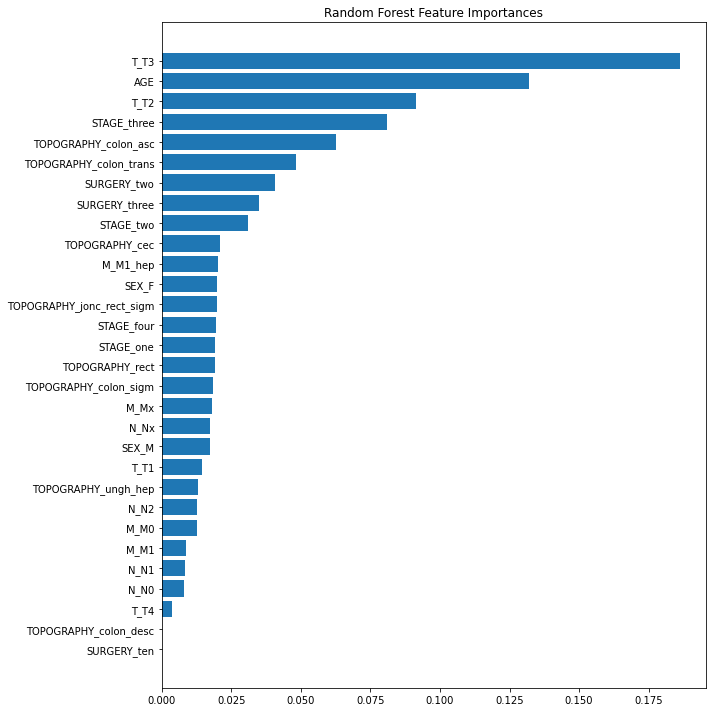

In [ ]:
# plot the impurity metric feature importances 
plot_impurity_metric_features( feature_importances, sorted_idx, feature_names)


***Question***

What are the 3 most important features? 

***T_T3, AGE, T_T2***


One of the downsides of the inbuilt impurity metric is that it can only be applied to training data. This doesn't give us any indication of which features will be the most important on unseen data. 

Instead, we can use the permutation importance to measure the feature importances on both the training and validation sets. 

Complete the `permutation_importance` function to calculate the importance of the diffierent features in the training dataset. Then use the `argsort()` to sort the features in order of importance again.

In [ ]:
# permutation method on both training and test
result = permutation_importance(estimator=best_clf , X=X_train, y=y_train, n_repeats=10, random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
print(sorted_idx)


[ 8 28 20 19  1  2 27  5 24 25 12 11 26 23 10  9 15 14  3 29 21  6 18 13
  0  7 22 16  4 17]


Use the function below to plot the permutation importances.

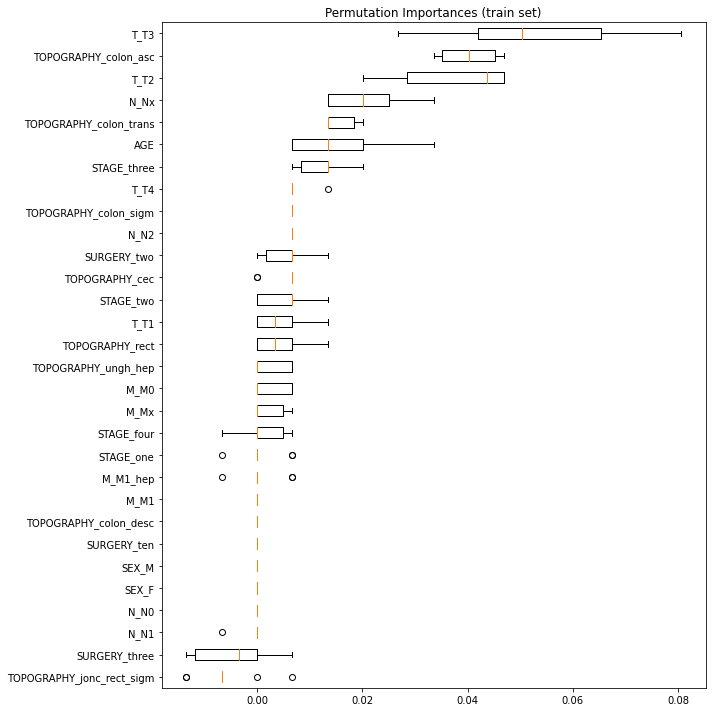

In [ ]:

def plot_perm_importance(result, sorted_idx, feature_names):

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.boxplot(
        result.importances[sorted_idx].T, vert=False, labels=feature_names[sorted_idx]
    )
    ax.set_title("Permutation Importances (train set)")
    fig.tight_layout()
    plt.show()
    
plot_perm_importance(result, sorted_idx, feature_names)


What do you notice about the difference between the two methods of doing feature selection? Why do you think this is?

***The most importantant features are different compared to the purity (Gini) based approach. This is likely because the impurity based approach can put more emphasis on variables with a wide variety of numeric values such as Age.

Another difference is that the permutation based approach has marked a lot of features as having zero importance whereas with the impurity most features have an importance***



Now calculate the permutation importance on the test set. 

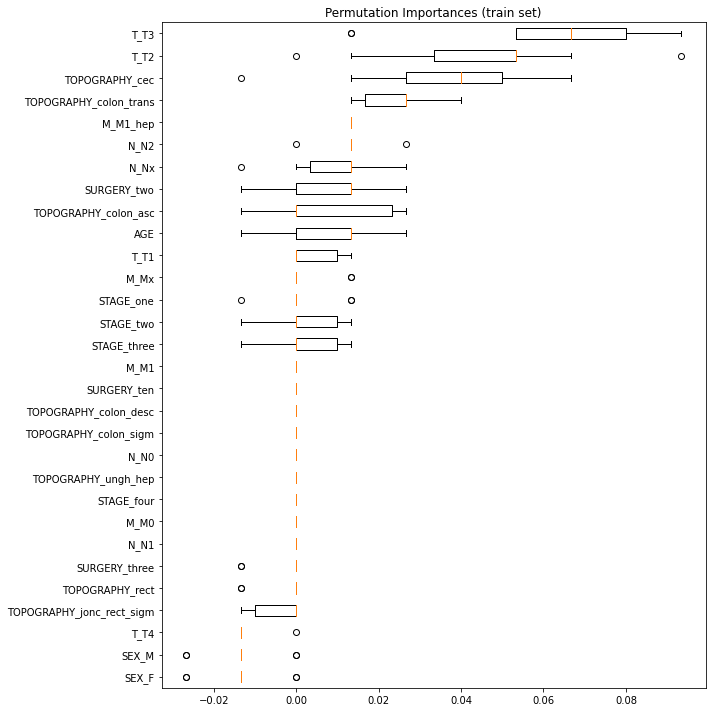

In [ ]:
result = permutation_importance(estimator=best_clf, X=X_test, y=y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()

plot_perm_importance(result, sorted_idx, feature_names)

What do you see in the test data?

Why do some of the importances go negative?

***The top most importance answer T-T3 is the same as with the training set however the orders of the importances below that have changed.***

***I think some features might go negative as they performed better with the shuffled data so are not good predictors***


(3 marks)